# Linear LFM

Replication of the paper by [Lawrence et al., 2006.](https://papers.nips.cc/paper/3119-modelling-transcriptional-regulation-using-gaussian-processes.pdf)

The dataset required is small and is available preprocessed here:

- https://drive.google.com/drive/folders/1Tg_3SlKbdv0pDog6k2ys0J79e1-vgRyd?usp=sharing

### Probesets

The original paper restricted their interest to 5 known targets of p53:

| Target       | Probeset     | Aliases    |
| :------------- | :----------: | :----------- |
| DDB2 |  203409_at    | |
| p21   | 202284_s_at | p21CIP1, CDKN1A |
| SESN1/hPA26   | 218346_s_at |  |
| BIK   | 205780_at |  |
| TNFRSF10b   | 209294_x_at, 209295_at, 210405_x_at |  |

In [1]:
import torch
import numpy as np
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from matplotlib import pyplot as plt
from os import path

from alfi.models import ExactLFM
from alfi.trainers import ExactTrainer
from alfi.datasets import P53Data
from alfi.plot import Plotter1d

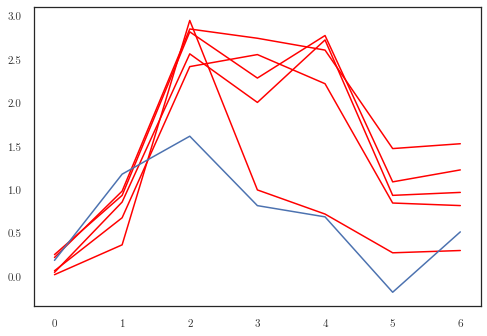

In [2]:
dataset = P53Data(replicate=0, data_dir='../../../data/')
ground_truth = P53Data.params_ground_truth()
class ConstrainedTrainer(ExactTrainer):
    def after_epoch(self):
        super().after_epoch()
        with torch.no_grad():
            sens = self.lfm.covar_module.sensitivity
            sens[3] = np.float64(1.)
            deca = self.lfm.covar_module.decay
            deca[3] = np.float64(0.8)
            self.lfm.covar_module.sensitivity = sens
            self.lfm.covar_module.decay = deca

for i in range(5):
    plt.plot(dataset.m_observed[0, i], color='red')
plt.plot(dataset.f_observed[0, 0])

In [3]:
model = ExactLFM(dataset, dataset.variance.reshape(-1))

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = ExactMarginalLogLikelihood(model.likelihood, model)

track_parameters = [
    'mean_module.raw_basal',
    'covar_module.raw_decay',
    'covar_module.raw_sensitivity',
    'covar_module.raw_lengthscale',
]


trainer = ConstrainedTrainer(model, [optimizer], dataset, loss_fn=loss_fn, track_parameters=track_parameters)
plotter = Plotter1d(model, dataset.gene_names)

In [4]:
model.likelihood.train()
a = trainer.train(epochs=150, report_interval=25)
a = np.array(a)

Epoch 001/150 - Loss: 1.20 (1.20) λ: [2.4933224]
Epoch 026/150 - Loss: 1.05 (1.05) λ: [2.412477]
Epoch 051/150 - Loss: 0.98 (0.98) λ: [2.16898]
Epoch 076/150 - Loss: 0.91 (0.91) λ: [1.8944939]
Epoch 101/150 - Loss: 0.84 (0.84) λ: [1.6568555]
Epoch 126/150 - Loss: 0.78 (0.78) λ: [1.4926062]


tensor([[1.4038]], grad_fn=<AddBackward0>)
tensor([ 0.,  2.,  4.,  6.,  8., 10., 12.])


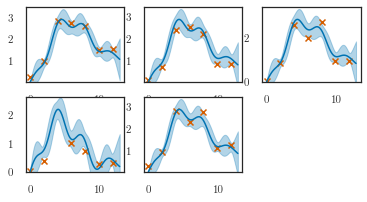

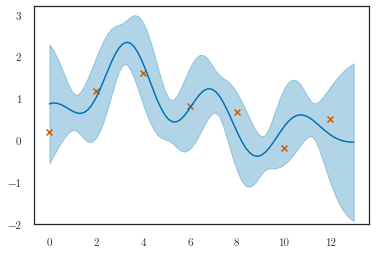

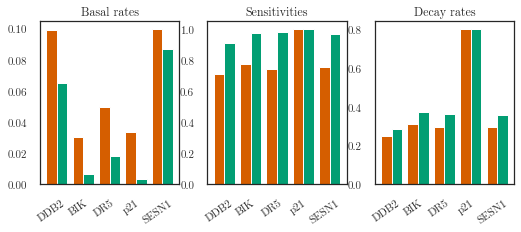

In [5]:
print(model.covar_module.lengthscale)
print(dataset.t_observed)
t_predict = torch.linspace(0, 13, 80, dtype=torch.float64)
p_m = model.predict_m(t_predict, jitter=1e-3)
p_f = model.predict_f(t_predict, jitter=1e-3)

plotter.plot_gp(p_m, t_predict,
                t_scatter=dataset.t_observed, y_scatter=dataset.m_observed)

plotter.plot_gp(p_f, t_predict,
                ylim=(-2, 3.2),
                t_scatter=dataset.t_observed, y_scatter=dataset.f_observed, num_samples=0)

labels = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
constraints = dict(model.named_constraints())
for key in ['mean_module.raw_basal', 'covar_module.raw_sensitivity', 'covar_module.raw_decay']:
    val = trainer.parameter_trace[key][-1].squeeze()
    if key + '_constraint' in constraints:
        val = constraints[key + '_constraint'].transform(val)
    kinetics.append(val.numpy())
kinetics = np.array(kinetics)
plotter.plot_double_bar(kinetics, titles=labels, ground_truths=ground_truth)
